# DEMO 

Read in the intake catalogues from the input to bias correction



#### required packages

In [1]:
import intake
import xarray as xr
from matplotlib import pyplot as plt

import glob
import pathlib
import traceback
from datetime import datetime


#### start a local Dask client

In [2]:
from dask.distributed import Client
client = Client()
client

2024-06-11 10:24:37,358 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-11 10:24:37,361 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-11 10:24:37,367 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0017.gadi.nci.org.au/39999/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0017.gadi.nci.org.au/39999/proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44647,Workers: 7
Dashboard: /node/gadi-cpu-bdw-0017.gadi.nci.org.au/39999/proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37879,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0017.gadi.nci.org.au/39999/proxy/42313/status,Memory: 0 B
Nanny: tcp://127.0.0.1:44645,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Obtain the desired catalogues of the simulations to processe

In [4]:
catalogue_path='/g/data/ia39/catalogues'
mRuns = sorted(glob.glob(catalogue_path+'/*ssp370*.json'))
print(len(mRuns))

13


In [5]:
# test loading all the catalogues of the data
for file in mRuns: 
    print(file)
    cat1=intake.open_esm_datastore(file)

/g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-CM2_ssp370_r4i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_ACCESS-ESM1-5_ssp370_r6i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_CESM2_ssp370_r11i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_CMCC-ESM2_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_EC-Earth3_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_MPI-ESM1-2-HR_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_BOM_NorESM2-MM_ssp370_r1i1p1f1_BARPA-R_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_ACCESS-CM2_ssp370_r4i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_ACCESS-ESM1-5_ssp370_r6i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_CESM2_ssp370_r11i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/catalogues/AGCD-05i_CSIRO_CMCC-ESM2_ssp370_r1i1p1f1_CCAM-v2203-SN_v1-r1_day.json
/g/data/ia39/

In [6]:
# From one catalogue list save variables
cat=intake.open_esm_datastore(mRuns[12])
mtmp=mRuns[12].split('/')
model_name=mtmp[5].split('.')
cat.unique()['variable'] #unique()['variable']

['hursmax', 'hursmin', 'pr', 'rsds', 'sfcWindmax', 'tasmax', 'tasmin']

In [7]:
%%time
# read in a few variables from one member
cat_subset=cat.search(variable={'pr','tasmax'})
dsets = cat_subset.to_dask(cdf_kwargs={'chunks': {'time': 365, 'lat': 691}})
#dsets = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 365, 'lat': 691}})
dsets

CPU times: user 14.3 s, sys: 1.6 s, total: 15.9 s
Wall time: 44.3 s


<xarray.Dataset>
Dimensions:    (time: 31025, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * time       (time) object 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lat        (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float64 112.0 112.0 112.1 112.2 ... 156.1 156.2 156.2 156.2
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(691, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(886, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(365, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                         CF-1.10
    activity_id:                         DD
    contact:                             ccam@csiro.au
    domain:                              Australia/AGCD
    domain_id:                           AGCD-05i
    driving_experiment:                  gap-filling scenario reaching 7.0 ba...
    ...                                  ...
    intake_esm_attrs:downscale_model:    CSIRO
    intake_esm_attrs:downscale_version:  CCAM-v2203-SN
    intake_esm_attrs:period:             v1-r1
    intake_esm_attrs:time_period:        fixed
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AGCD-05i.EC-Earth3.ssp370.r1i1p1f1.C...

## Do a few simple calculations and plots

CPU times: user 1.16 s, sys: 173 ms, total: 1.34 s
Wall time: 7.06 s


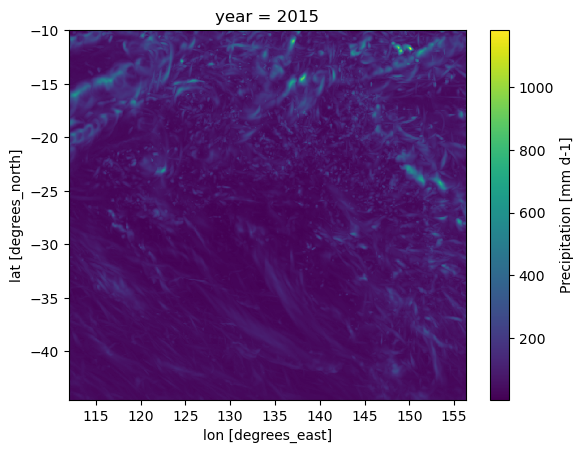

In [8]:
%%time
# compute the maximum daily pr for each year using groupby
ds_ymax = dsets.pr.groupby('time.year').max('time')
# plot first year value
ds_ymax[0,:,:].plot()

CPU times: user 12.4 s, sys: 1.33 s, total: 13.7 s
Wall time: 1min 51s


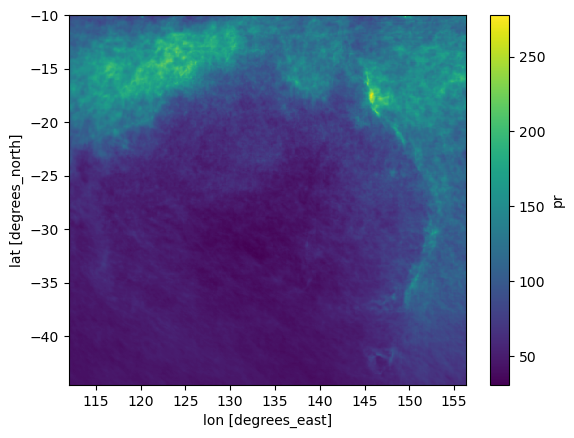

In [13]:
%%time
ds_ymax.load()
# plot the average daily maximum pr
ds_ymax.mean('year').plot()

In [14]:
%%time
ds_ymax.to_netcdf('/g/data/xv83/rxm599/acs/'+model_name[0]+'.nc')

CPU times: user 85.9 ms, sys: 201 ms, total: 287 ms
Wall time: 322 ms


# The End

In [11]:
#client.shutdown()